# Portfolio Optimization
The code here optmizes a stock portfolio by maximizing Sharpe ratio and determines optimal allocations for a pre-defined ticker list. The list of stocks to analyze is added to tickers.csv file in data folder. You can modify this file as per your need. First, the program fetches data from Alpha Vantage website and saves them as CSV in data folder. You will need to register with Alpha Vantage and get a key to fetch data. It is free currently. Next, the program reads the downloaded csv files and runs optimization to determine optimal portfolio allocations. Please don't consider this a recommendation to do actual trading. Use this program more as an educational tool.
<p></p>
Most of the concepts used here are taken from the course "Machine Learning for Trading" offered on Udacity by Prof. Tucker Balch. The ideas are well presented in the course. He also provides a lot of code which is very helpful.
<p></p>
I would also like to thank Mark Trinquero for his <a href="https://github.com/mtrinquero/MachineLearning_FinancialTradingApplications/blob/master/Portfolio_Optimization/portfolio/analysis.py">optimization code</a> on Github. Some of the functions from his code are used here.

In [12]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import scipy.optimize as spo

In [4]:
# Your key here
# Add an environment variable ALPHA_VANTAGE_KEY on your machine and set your key obtained from Alpha_vantage
key = os.environ['ALPHA_VANTAGE_KEY']
# Chose your output format, or default to JSON (python dict)
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

In [17]:
def load_tickers():
    tickers = []
    import csv
    with open('./data/tickers.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            tickers.append(row[0])
    
    return tickers

def fetch_data(ticker, freq = 'D'):
    '''
    Fetch data from Alpha Vantage
    '''
    if freq == 'D':
        return ts.get_daily(symbol=ticker)
    elif freq == 'W':
        return ts.get_weekly(symbol=ticker)
    else:
        return ts.get_monthly(symbol=ticker)

def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method="ffill", inplace=True)
    df_data.fillna(method="bfill", inplace=True)

def symbol_to_path(ticker, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(ticker)))

def get_data(tickers, dates):
    """Read stock data for given tickers from CSV files."""
    df = pd.DataFrame(index=dates)
    
    if "SPY" not in tickers:  # add SPY for reference, if absent
       tickers_list = ['SPY'] + tickers

    for ticker in tickers_list:
        file_path = symbol_to_path(ticker)
        df_temp = pd.read_csv(file_path, parse_dates=True, index_col="date",
            usecols=["date", "close"], na_values=["nan"])
        df = df.join(df_temp)
        df = df.rename(columns={"close": ticker})
        if ticker == "SPY":  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])
    return df

def compute_daily_returns(df):
    """Compute daily return values."""
    daily_returns = df.copy()
    # comput daily returns for row 1 onwards
    daily_returns = (df / df.shift(1)) - 1 # much easier wih Pandas
    daily_returns.iloc[0] = 0 # set daily returns for row 0 to 0
    return daily_returns

def get_normalized(df):
    return df / df.iloc[0]

def get_portfolio_value(df_prices, allocs, start_val=1):
    """Compute daily portfolio value given stock prices, allocations and starting value.

    Parameters
    ----------
        prices: daily prices for each stock in portfolio
        allocs: initial allocations, as fractions that sum to 1
        start_val: total starting value invested in portfolio (default: 1)

    Returns
    -------
        port_val: daily portfolio value
    """
    # normalized data frame
    df_norm = get_normalized(df_prices)
    # normalized allocations data frame
    df_alloc = df_norm * allocs
    # position values data frame
    df_pos_vals = df_alloc * start_val
    # total value of the portfoli at a given day
    df_portolio_val = df_pos_vals.sum(axis=1)
    return df_portolio_val

def get_portfolio_stats(df_port_val, allocs, daily_rf=0, samples_per_year=252):
    """Calculate statistics on given portfolio values.

    Parameters
    ----------
        port_val: daily portfolio value
        daily_rf: daily risk-free rate of return (default: 0%)
        samples_per_year: frequency of sampling (default: 252 trading days)

    Returns
    -------
        cum_ret: cumulative return
        avg_daily_ret: average of daily returns
        std_daily_ret: standard deviation of daily returns
        sharpe_ratio: annualized Sharpe ratio
    """
    # Portfolio Statistics
    daily_ret = (df_port_val / df_port_val.shift(1)) - 1
    cum_ret = (df_port_val[-1] / df_port_val[0]) - 1
    std_daily_ret = daily_ret.std()
    avg_daily_ret = daily_ret.mean()

    # annualized based on frequency of sampleing (daily)
    k = np.sqrt(samples_per_year)
    sharpe_ratio = k * np.mean(avg_daily_ret - daily_rf) / std_daily_ret
    return cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio

def plot_normalized_data(df_prices, title="Normalized prices", xlabel="Date", ylabel="Normalized price"):
    """Normalize given stock prices and plot for comparison.

    Parameters
    ----------
        df: DataFrame containing stock prices to plot (non-normalized)
        title: plot title
        xlabel: X-axis label
        ylabel: Y-axis label
    """
    # normalized data frame
    df = get_normalized(df_prices)
    # http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.text
    dfp = df.plot(title=title, fontsize=12)
    # http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.set_xlabel
    dfp.set_xlabel(xlabel)
    dfp.set_ylabel(ylabel)
    plt.show()


def assess_portfolio(start_date, end_date, tickers, allocs, start_val=1):
    """Simulate and assess the performance of a stock portfolio."""
    # Read in closing prices for given tickers, date range
    dates = pd.date_range(start_date, end_date)
    prices_all = get_data(tickers, dates)  # automatically adds SPY
    prices = prices_all[tickers]  # only portfolio tickers
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later

    # Get daily portfolio value
    port_val = get_portfolio_value(prices, allocs, start_val)

    # Get portfolio statistics (note: std_daily_ret = volatility)
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = get_portfolio_stats(port_val, allocs)

    # Print statistics
    print ("Start Date:", start_date)
    print ("End Date:", end_date)
    print ("tickers:", tickers)
    print ("Allocations:", allocs)
    print ("Sharpe Ratio:", sharpe_ratio)
    print ("Volatility (stdev of daily returns):", std_daily_ret)
    print ("Average Daily Return:", avg_daily_ret)
    print ("Cumulative Return:", cum_ret)

    # Compare daily portfolio value with SPY using a normalized plot
    df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
    plot_normalized_data(df_temp, title="Daily portfolio value and SPY")


def sharpe_func(allocs, df_prices):
    "compute sharpe ratio given allocs and price data"
    port_val = get_portfolio_value(df_prices, allocs, 1)
    port_stats = get_portfolio_stats(port_val, allocs)
    sharpe_ratio = port_stats[3]
    return (-1 * sharpe_ratio)

def find_optimal_allocations(df_prices):
    """Find optimal allocations for a stock portfolio, optimizing for Sharpe ratio.

    Parameters
    ----------
        df_prices: daily prices for each stock in portfolio

    Returns
    -------
        allocs: optimal allocations, as fractions that sum to 1.0
    """
     #length of tickers to optimize
    noa = len(df_prices.columns)
    #initial guess on allocations (equal weight distribution)
    guess = noa * [1. / noa,]

    #constraint that all the allocations must sum to 1.0
    cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})
    #bound that each allocation must be between 0.0 and 1.0
    bnds = tuple((0, 1) for x in range(noa))

    #call the optimizer to minimize the negative value of the sharpe ratio
    opts = spo.minimize(sharpe_func, guess, args=(df_prices,), method='SLSQP', options={'disp':True}, bounds=bnds, constraints=cons)
    allocs = opts['x']
    return allocs


def optimize_portfolio(start_date, end_date, tickers):
    """Simulate and optimize portfolio allocations."""
    # Read in adjusted closing prices for given tickers, date range
    dates = pd.date_range(start_date, end_date)
    prices_all = get_data(tickers, dates)  # automatically adds SPY
    prices = prices_all[tickers]  # only portfolio tickers
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later

    # Get optimal allocations
    allocs = find_optimal_allocations(prices)
    allocs = allocs / np.sum(allocs)  # normalize allocations, if they don't sum to 1.0

    # Get daily portfolio value (already normalized since we use default start_val=1.0)
    port_val = get_portfolio_value(prices, allocs)

    # Get portfolio statistics (note: std_daily_ret = volatility)
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = get_portfolio_stats(port_val, allocs)

    # Print statistics
    print ("Start Date:", start_date)
    print ("End Date:", end_date)
    print ("tickers:", tickers)
    print ("Optimal Allocations:", allocs)
    print ("Sharpe Ratio:", sharpe_ratio)
    print ("Volatility (stdev of daily returns):", std_daily_ret)
    print ("Average Daily Return:", avg_daily_ret)
    print ("Cumulative Return:", cum_ret)
    
    # Compare daily portfolio value with normalized SPY
    normed_SPY = get_normalized(prices_SPY)
    df_temp = pd.concat([port_val, normed_SPY], keys=['Portfolio', 'SPY'], axis=1)
    plot_normalized_data(df_temp, title="Daily Portfolio Value and SPY")
    return allocs

In [11]:
# Load ticker file
tickers = load_tickers()

if 'SPY' not in tickers:  # add SPY for reference, if absent
        tickers = ['SPY'] + tickers
        
# Fetch data. Pause after every 5 tickers since the site allows limited stocks at a time
count = 0
for ticker in tickers:
    count += 1 
    ticker_data, ticker_meta_data = fetch_data(ticker)
    ticker_data.columns = ["open", "high", "low", "close", "volume"]
    ticker_data.to_csv(r'./data/' + ticker + '.csv')
    if count % 5 == 0:
        time.sleep(70)

Tickers: ['CMG', 'GOOG', 'UNH', 'GILD', 'NVDA', 'GLD', 'AAPL', 'MSFT']
[0, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
Start Date: 2019-12-12
End Date: 2020-05-06
tickers: ['CMG', 'GOOG', 'UNH', 'GILD', 'NVDA', 'GLD', 'AAPL', 'MSFT']
Allocations: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Sharpe Ratio: 0.8953602996357359
Volatility (stdev of daily returns): 0.02832597962984319
Average Daily Return: 0.001597653157018694
Cumulative Return: 0.12577821302351055


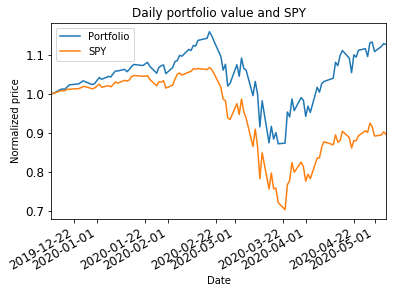

-----------------------------------------
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.8713905588000377
            Iterations: 9
            Function evaluations: 92
            Gradient evaluations: 9
Start Date: 2019-12-12
End Date: 2020-05-06
tickers: ['CMG', 'GOOG', 'UNH', 'GILD', 'NVDA', 'GLD', 'AAPL', 'MSFT']
Optimal Allocations: [0.         0.         0.         0.0603882  0.10750249 0.83210931
 0.         0.        ]
Sharpe Ratio: 1.8713905588000452
Volatility (stdev of daily returns): 0.014113707068228206
Average Daily Return: 0.001663815872558586
Cumulative Return: 0.16750181521531027


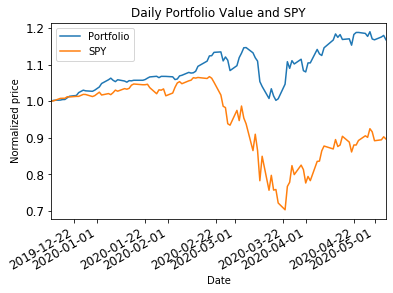

GILD 0.060388201727548815
NVDA 0.10750248715093529
GLD 0.832109311121516


In [20]:
# create dataframe with closing price and returns for finding optimal portfolio
tickers = load_tickers()
print('Tickers:', tickers)

start_date = "2019-12-12"
end_date = "2020-05-06"
dates = pd.date_range(start_date, end_date)  # date range as index
df_data = get_data(tickers, dates)

start_val = 100000
allocs = [0] + (df_data.shape[1] - 1) * [1. / (df_data.shape[1] - 1)]
print(allocs)

# Convert allocs into array
allocs = np.array(allocs)

# # Portfolio value calculation
# df_port_val = get_portfolio_value(df_data, allocs, start_val)

# plot_normalized_data(df_data)

# # Get stats
# cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = get_portfolio_stats(df_port_val, allocs)

# print("cum_return = ", cum_ret)
# print("avg_daily_ret = ", avg_daily_ret)
# print("std_daily_ret = ", std_daily_ret)
# print("sharp_ratio = ", sharpe_ratio)
# print("-----------------------------------------")

# test
# remove allocations for SPY
allocs = allocs[1:]
assess_portfolio(start_date, end_date, tickers, allocs, start_val)
print("-----------------------------------------")

# Find optimal allocations
optimal_allocs = optimize_portfolio(start_date, end_date, tickers)
for i, x in enumerate(optimal_allocs):
    if x > 0.01:
        print(tickers[i], x)